In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Activation, Flatten, BatchNormalization,Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/'MyDrive'/'ai_for_healthcare'/

/content/drive/MyDrive/ai_for_healthcare


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Load image data
train_dir = 'dataset/Training'
test_dir = 'dataset/Testing'

batch_size = 32
img_size = 224

# Image data generator / preprocessing
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                    width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest",validation_split = 0.2)

datagen_test = ImageDataGenerator(rescale=1./255)

# Define Train and Test images using flow_from_directory
train_data_gen = datagen.flow_from_directory(
    directory = train_dir,
    shuffle=True,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'training'
)

validation_data_gen = datagen.flow_from_directory(
    directory = train_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    shuffle = False, 
    subset = 'validation'
)

test_data_gen = datagen_test.flow_from_directory(
    directory = test_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    shuffle = False
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
model_name = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layers in model_name.layers[:]:
    layers.trainable = False

    
x = Flatten()(model_name.output)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001), )(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=model_name.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=1e-3)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr

    return lr

lr_metric = get_lr_metric(optimizer)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc',lr_metric])

In [ ]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=13)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=7, mode='auto', factor=0.2)
callbacks = [early_stop,reduce_lr]


In [ ]:
model_history = model.fit(train_data_gen, 
                          validation_data=validation_data_gen,
                          epochs=100,
                           steps_per_epoch=train_data_gen.samples//batch_size,
                          validation_steps=validation_data_gen.samples//batch_size,
                          callbacks = callbacks)

Epoch 1/100
71/71 [==============================] - 599s 8s/step - loss: 1.8832 - acc: 0.6042 - lr: 1.0000e-03 - val_loss: 3.1465 - val_acc: 0.5901 - val_lr: 0.0010
Epoch 2/100
71/71 [==============================] - 44s 623ms/step - loss: 1.1753 - acc: 0.7514 - lr: 1.0000e-03 - val_loss: 4.3313 - val_acc: 0.4743 - val_lr: 0.0010
Epoch 3/100
71/71 [==============================] - 43s 601ms/step - loss: 1.0498 - acc: 0.7914 - lr: 1.0000e-03 - val_loss: 1.3125 - val_acc: 0.7077 - val_lr: 0.0010
Epoch 4/100
71/71 [==============================] - 43s 605ms/step - loss: 0.9344 - acc: 0.8032 - lr: 1.0000e-03 - val_loss: 1.4847 - val_acc: 0.6526 - val_lr: 0.0010
Epoch 5/100
71/71 [==============================] - 43s 605ms/step - loss: 0.9365 - acc: 0.8065 - lr: 1.0000e-03 - val_loss: 1.1845 - val_acc: 0.7132 - val_lr: 0.0010
Epoch 6/100
71/71 [==============================] - 43s 608ms/step - loss: 0.8625 - acc: 0.8157 - lr: 1.0000e-03 - val_loss: 1.0214 - val_acc: 0.7518 - val_lr: 0

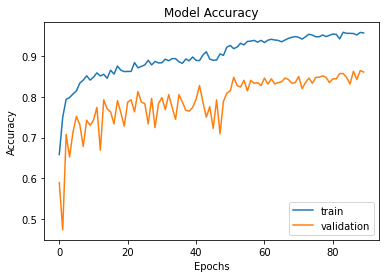

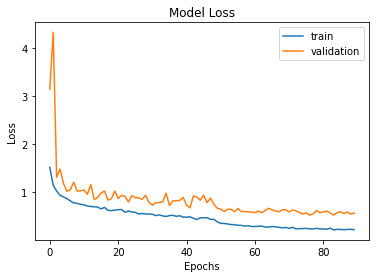

In [ ]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# History for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
Y_pred = model.predict(validation_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Class Labels
class_labels = list(validation_data_gen.class_indices.keys())

# Validation classes
y_val = validation_data_gen.classes

print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))
print()
print('Classification Report')
report = classification_report(y_val, y_pred, target_names=class_labels)
print(report)

Confusion Matrix
[[147  15   2   1]
 [ 10 134   0  20]
 [  0   7  72   0]
 [  4  16   3 142]]

Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.89      0.90       165
meningioma_tumor       0.78      0.82      0.80       164
        no_tumor       0.94      0.91      0.92        79
 pituitary_tumor       0.87      0.86      0.87       165

        accuracy                           0.86       573
       macro avg       0.87      0.87      0.87       573
    weighted avg       0.87      0.86      0.86       573



Confusion matrix, without normalization


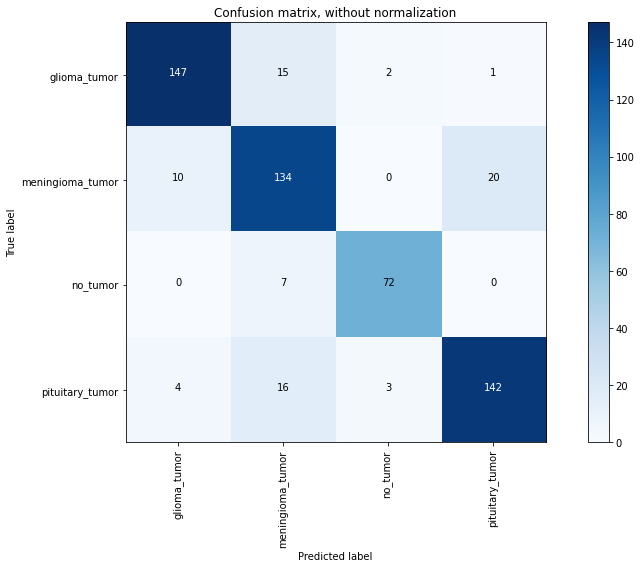

In [ ]:
# Defining confusion matrix function to plot that can be normalized as well

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plotting my model
cnf_matrix = confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,8))
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')
plt.tight_layout()

In [ ]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(224,224,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(4, activation='softmax')(x3)
model1 = tf.keras.Model(inputs=inputs3, outputs=outputs3)
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
his=model1.fit(train_data_gen, 
              validation_data=validation_data_gen,
              epochs=50,
              steps_per_epoch=train_data_gen.samples//batch_size,
              validation_steps=validation_data_gen.samples//batch_size)

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/50
71/71 [==============================] - 62s 728ms/step - loss: 1.6936 - accuracy: 0.4293 - val_loss: 1.1917 - val_accuracy: 0.4926
Epoch 2/50
71/71 [==============================] - 47s 666ms/step - loss: 0.8744 - accuracy: 0.6529 - val_loss: 1.0632 - val_accuracy: 0.5404
Epoch 3/50
71/71 [==============================] - 48s 670ms/step - loss: 0.7451 - accuracy: 0.7019 - val_loss: 1.0601 - val_accuracy: 0.5404
Epoch 4/50
71/71 [==============================] - 48s 673ms/step - loss: 0.7369 - accuracy: 0.7171 - val_loss: 0.9280 - val_accuracy: 0.5643
Epoch 5/50
71/71 [==============================] - 48s 674ms/step - loss: 0.6385 - accuracy: 0.7399 - val_loss: 0.8997 - val_accuracy: 0.6158
Epoch 6/50
71/71 [==============================] - 48s 671ms/step - loss: 0.5680 - accuracy: 0.7738 - val_loss: 0.9447 - val_accuracy: 0.5864
Epoch 7/50
71/71 [==============================] - 48s 674ms/step - loss: 0.